# Car Price prediction<br>
### Прогнозирование стоимости автомобиля по характеристикам

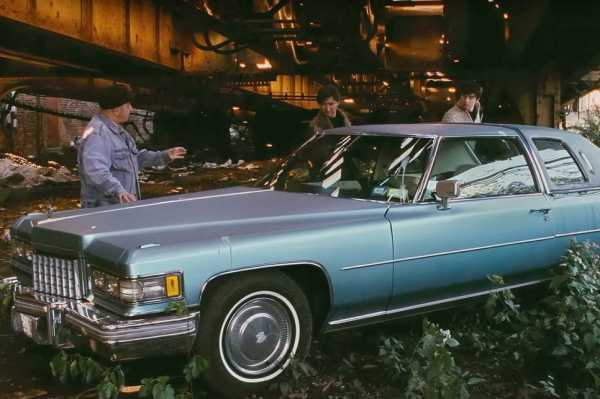

Задача проекта: создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам.
Модель создается на основе объединения алгоритмов ML и DL.
Результатом выполнения работы является получение наименьшего MAPE на тестовом датасете в соревновании на [Kaggle](https://www.kaggle.com/c/sf-dst-car-price-prediction-part2).

In [120]:
import warnings
warnings.filterwarnings("ignore")

In [121]:
!pip install -q pymystem3

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random
import os
import sys
import PIL
import cv2

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

from catboost import CatBoostRegressor

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import albumentations
import re
from nltk.corpus import stopwords
from pymystem3 import Mystem

In [123]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [124]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## Exploratory Data Analysis (EDA)

In [125]:
DATA_DIR = '../input/sf-data-module-8/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [126]:
train.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,...,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,...,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,...,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,...,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,...,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


### Удаление дубликатов

Первым делом, избавляемся от дублирующих значений в нашем датасете.

In [127]:
train.shape

(6682, 22)

In [128]:
train = train.drop_duplicates()
train.shape

(6682, 22)

Дубликатов не оказалось, но проверить мы были должны.

In [129]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = np.NaN # целевая переменная, котрую мы должны предсказать

df = train.append(test).reset_index(drop=True)

In [130]:
df.shape

(8353, 23)

### Обработка пропусков

Посмотрим на количество пропусков для каждого признака.

In [131]:
df.isnull().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                   1671
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                5418
ПТС                        0
Привод                     0
Руль                       0
sample                     0
dtype: int64

In [132]:
# Слишком много пропусков у признака 'Владение'. Удаляем целиком
df.drop(columns = ['Владение'], inplace = True)
# пропуск в признаке 'Владельцы' заполняем наиболее частым признаком
df['Владельцы'].fillna(df.Владельцы.value_counts().index[0], inplace = True)

In [133]:
df.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,sample
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,...,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,Оригинал,полный,Левый,1
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,...,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,Оригинал,передний,Левый,1
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,...,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,Оригинал,полный,Левый,1
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,...,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,Оригинал,передний,Левый,1
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,...,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,Оригинал,передний,Левый,1


### Очистка данных

Посмотрим на признаки, и как их можно преобразовать.

In [134]:
df.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'price', 'productionDate', 'sell_id',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'ПТС',
       'Привод', 'Руль', 'sample'],
      dtype='object')

#### 'bodyType'
Тип кузова

In [135]:
df['bodyType'].value_counts() # типы кузовов в объединенном датасете

седан                   3541
внедорожник 5 дв.       2896
купе                     543
хэтчбек 5 дв.            364
лифтбек                  299
универсал 5 дв.          196
минивэн                  178
купе-хардтоп             111
родстер                   88
хэтчбек 3 дв.             57
кабриолет                 54
компактвэн                 8
внедорожник 3 дв.          5
лимузин                    5
внедорожник открытый       4
пикап двойная кабина       3
седан 2 дв.                1
Name: bodyType, dtype: int64

In [136]:
df[df['sample'] == 0]['bodyType'].value_counts() # типы кузовов в тестовом датасете

седан                   698
внедорожник 5 дв.       581
купе                    116
хэтчбек 5 дв.            68
лифтбек                  54
универсал 5 дв.          43
минивэн                  32
родстер                  28
купе-хардтоп             20
хэтчбек 3 дв.            16
кабриолет                10
внедорожник открытый      2
внедорожник 3 дв.         2
пикап двойная кабина      1
Name: bodyType, dtype: int64

Мы видим, что авто с кузовами "компактвэн", "лимузин" и "седан 2 дв." нет в тестовом датасете. <br>
Следовательно, удаляем их из обучающей выборке.

In [137]:
df = df[~df['bodyType'].isin(["компактвэн", "лимузин", "седан 2 дв."])].reset_index(drop=True)

#### 'engineDisplacement'

Объем двигателя измеряется в литрах. Приведем данные к числовым значениям.<br> Показатель *'undefined LTR*' заменим средним значением.

In [138]:
df['engineDisplacement'] = df['engineDisplacement'].apply(lambda x: float(x[:3]) if x != 'undefined LTR' else np.nan)

In [139]:
df['engineDisplacement'] = df['engineDisplacement'].fillna(df['engineDisplacement'].mean())

#### 'enginePower'

In [140]:
# переводим в числовое значение мощность двигателя
df['enginePower'] = df['enginePower'].apply(lambda x: int(x[:3]))

#### 'model_info'

In [141]:
set(df['model_info'].unique()) - set(df[df['sample'] == 0]['model_info'].unique())

{'100',
 'A_KLASSE_AMG',
 'CLC_KLASSE',
 'GLS_KLASSE_AMG',
 'I8',
 'None',
 'R8',
 'RS7',
 'RSQ3',
 'S3',
 'SLC_KLASSE',
 'SLC_KLASSE_AMG',
 'SQ5',
 'SQ7',
 'W201',
 'X3_M',
 'Z1',
 'Z8'}

Есть ряд моделей, которые отсутствуют в тестовом дасете.<br>
Исключим их из нашего датасета.

In [142]:
non_model_info = set(df['model_info'].unique()) - set(df[df['sample'] == 0]['model_info'].unique())
df = df[~df['model_info'].isin(non_model_info)].reset_index(drop=True)

#### 'Владельцы'

Приведем информацию к числовому виду:

In [143]:
def owners(x):
    if x == '1\xa0владелец':
        return 1
    elif x == '2\xa0владельца':
        return 2
    elif x == '3 или более':
        return 3
    else:
        return x

In [144]:
df['Владельцы'] = df['Владельцы'].apply(owners)

### Удаление признаков

Признак <b>'description'</b>, <b>'sell_id'</b> понадобятся далее. Перед удалением, сохраним о них информацию.<br>
Информация из признаков <b>'name'</b> и <b>'vehicleConfiguration'</b> дублируют информацию из других признаков.

In [145]:
description = df['description'] # понадобится в блоке с NLP
df_cv = df[['sell_id', 'price']] # понадобится в блоке с картинками
df.drop(['description', 'sell_id', 'name', 'vehicleConfiguration'], axis=1, inplace=True)

In [146]:
df.head()

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,numberOfDoors,price,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,sample
0,седан,BMW,чёрный,3.0,272,бензин,245000,2007,5ER,4,599000.0,2007,автоматическая,3,Оригинал,полный,Левый,1
1,седан,AUDI,серебристый,2.8,204,бензин,183000,2011,A6,4,850000.0,2011,вариатор,2,Оригинал,передний,Левый,1
2,седан,MERCEDES,чёрный,3.5,306,бензин,122733,2009,E_KLASSE,4,1325000.0,2013,автоматическая,3,Оригинал,полный,Левый,1
3,седан,AUDI,белый,2.0,180,бензин,151000,2011,A6,4,815000.0,2011,вариатор,3,Оригинал,передний,Левый,1
4,лифтбек,AUDI,белый,1.8,160,бензин,140000,2007,A5,5,810000.0,2011,вариатор,3,Оригинал,передний,Левый,1


### Группировка признаков

Полученные признаки сгруппируем в три категории по типу их обработки (категориальные  и числовые) для дальнейшего удобного анализа:

In [147]:
df.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_info', 'numberOfDoors',
       'price', 'productionDate', 'vehicleTransmission', 'Владельцы', 'ПТС',
       'Привод', 'Руль', 'sample'],
      dtype='object')

In [148]:
# разобъем данные по категориям
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate']
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль']

### Устранение выбросов

Посмотрим на выбросы:

<AxesSubplot:>

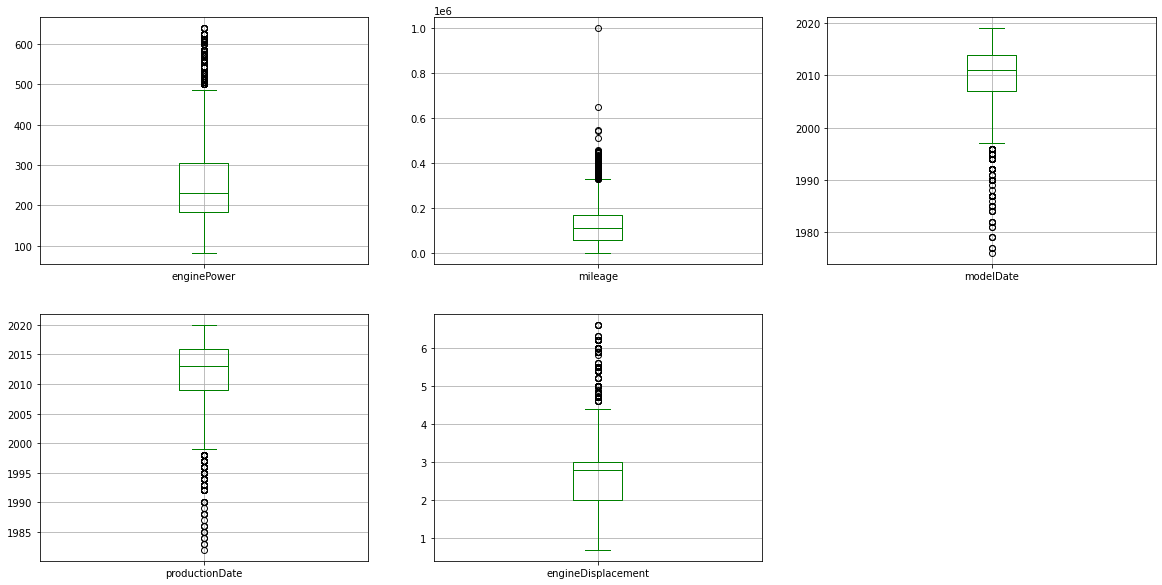

In [149]:
fig = plt.figure(figsize=(20, 10))

ax_1 = fig.add_subplot(2, 3, 1)
ax_2 = fig.add_subplot(2, 3, 2)
ax_3 = fig.add_subplot(2, 3, 3)
ax_4 = fig.add_subplot(2, 3, 4)
ax_5 = fig.add_subplot(2, 3, 5)


df[df['sample'] == 1].boxplot('enginePower', color='green', ax=ax_1)
df[df['sample'] == 1].boxplot('mileage', color='green', ax=ax_2)
df[df['sample'] == 1].boxplot('modelDate', color='green', ax=ax_3)
df[df['sample'] == 1].boxplot('productionDate', color='green',ax=ax_4)
df[df['sample'] == 1].boxplot('engineDisplacement', color='green', ax=ax_5)

Аномальные результаты присутствуют как в тренеровочной, так и в тестовой выборке. Поэтому, выбросы удалять не стал.

### Распределение числовых признаков

Посмотрим на распределние наших признаков.

<AxesSubplot:title={'center':"Распределение по признаку 'productionDate'"}, ylabel='Frequency'>

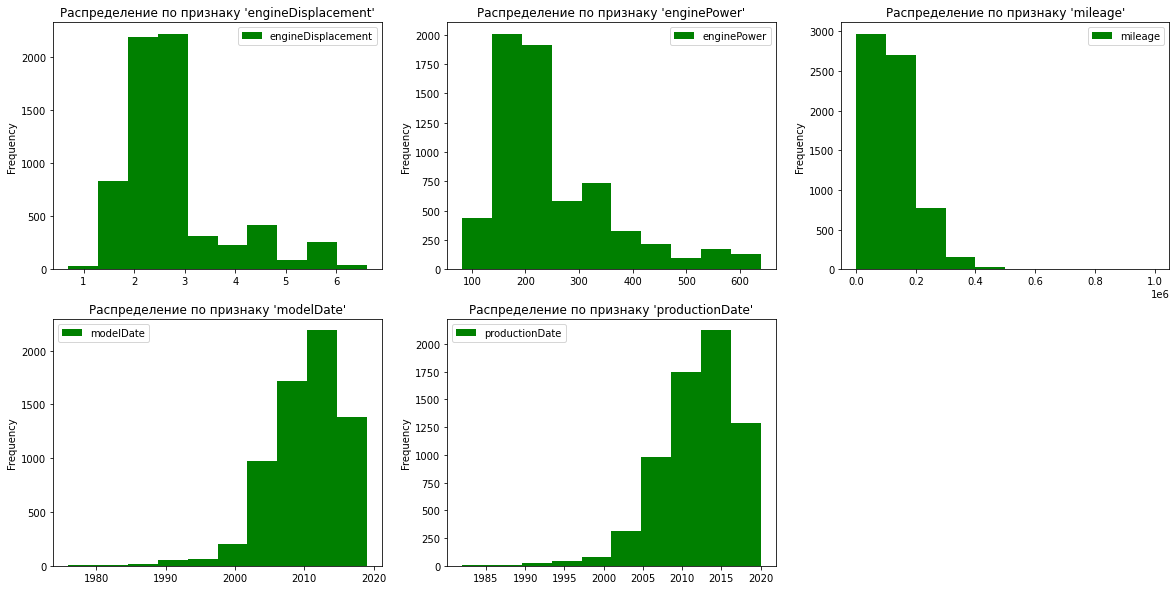

In [150]:
fig = plt.figure(figsize=(20, 10))

ax_1 = fig.add_subplot(2, 3, 1)
ax_2 = fig.add_subplot(2, 3, 2)
ax_3 = fig.add_subplot(2, 3, 3)
ax_4 = fig.add_subplot(2, 3, 4)
ax_5 = fig.add_subplot(2, 3, 5)

df[df['sample'] == 1].plot(y='engineDisplacement', kind='hist', color='green', title="Распределение по признаку 'engineDisplacement'", ax=ax_1)
df[df['sample'] == 1].plot(y='enginePower', kind='hist', color='green', title="Распределение по признаку 'enginePower'", ax=ax_2)
df[df['sample'] == 1].plot(y='mileage', kind='hist', color='green', title="Распределение по признаку 'mileage'", ax=ax_3)
df[df['sample'] == 1].plot(y='modelDate', kind='hist', color='green', title="Распределение по признаку 'modelDate'", ax=ax_4)
df[df['sample'] == 1].plot(y='productionDate', kind='hist', color='green', title="Распределение по признаку 'productionDate'", ax=ax_5)

Как видно, распределние числовых признаков далеко от нормального. Нужно провести стандартизацию признаков.

### Стандартизация числовых признаков

In [151]:
x = df.loc[:, num_cols].values

x_scaled = StandardScaler().fit_transform(x)
df[num_cols] = pd.DataFrame(x_scaled) 

Посмотрим на графики после стандартизации:

<AxesSubplot:title={'center':"Распределение по признаку 'productionDate'"}, ylabel='Frequency'>

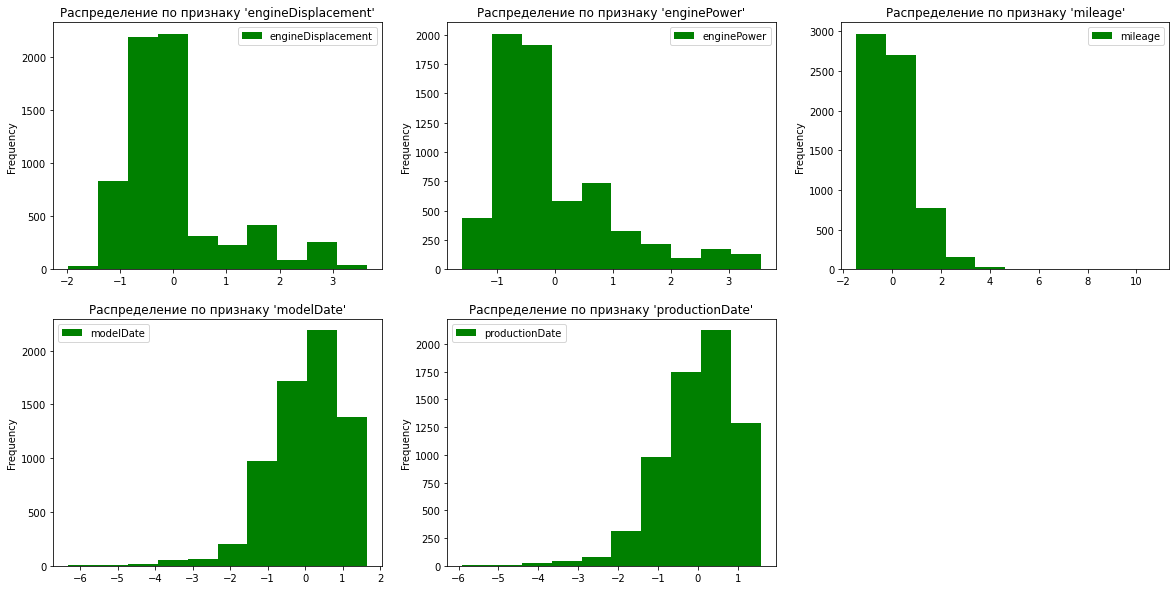

In [152]:
fig = plt.figure(figsize=(20, 10))

ax_1 = fig.add_subplot(2, 3, 1)
ax_2 = fig.add_subplot(2, 3, 2)
ax_3 = fig.add_subplot(2, 3, 3)
ax_4 = fig.add_subplot(2, 3, 4)
ax_5 = fig.add_subplot(2, 3, 5)

df[df['sample'] == 1].plot(y='engineDisplacement', kind='hist', color='green', title="Распределение по признаку 'engineDisplacement'", ax=ax_1)
df[df['sample'] == 1].plot(y='enginePower', kind='hist', color='green', title="Распределение по признаку 'enginePower'", ax=ax_2)
df[df['sample'] == 1].plot(y='mileage', kind='hist', color='green', title="Распределение по признаку 'mileage'", ax=ax_3)
df[df['sample'] == 1].plot(y='modelDate', kind='hist', color='green', title="Распределение по признаку 'modelDate'", ax=ax_4)
df[df['sample'] == 1].plot(y='productionDate', kind='hist', color='green', title="Распределение по признаку 'productionDate'", ax=ax_5)

Признаки стали более равномерно распределены.

### Оценка корреляций

Оценим корреляцию Пирсона для непрерывных переменных:

<AxesSubplot:>

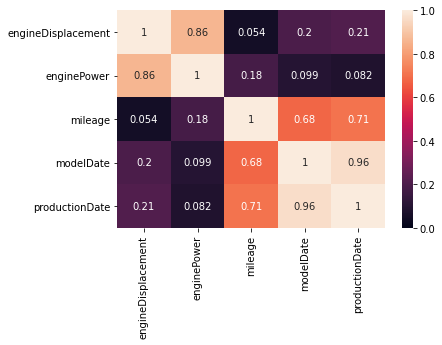

In [153]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Как мы можем заметить существует значительная корреляция между <b>'modelDate'</b> и <b>'productionDate'.</b>

### Значимость числовых переменных

<AxesSubplot:>

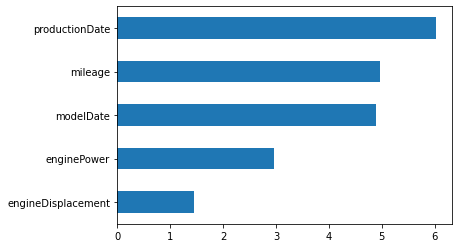

In [154]:
imp_num = pd.Series(f_classif(df[num_cols][df['sample'] == 1], df['price'][df['sample'] == 1])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Признак **'productionDate'** оказался самым значимым из числовых.

### Обработка категориальных переменных

In [155]:
# произведем LabelEncoder категориальных признаков, чтобы оценить их значимость
lbl_encode = LabelEncoder()

for i in cat_cols:
    df[i] = lbl_encode.fit_transform(df[i])

### Значимость категориальных переменных

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn.

<AxesSubplot:>

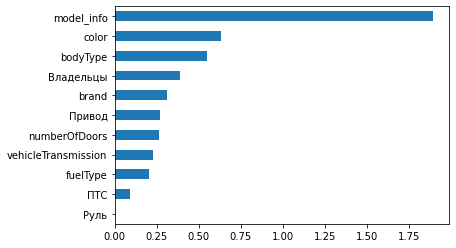

In [156]:
imp_cat = pd.Series(mutual_info_classif(df[cat_cols][df['sample'] == 1], df['price'][df['sample'] == 1],
                                     discrete_features =True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Признак **'model_info'** оказался самым важным из категориальных.

### OneHotEncoder

In [157]:
# сделаем OneHotEncoder для категориальных признаков
df = pd.get_dummies(df, columns = cat_cols)

### Split data

In [158]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

## Model CatBoostRegressor

In [159]:
# разобъем выборку на обучающую и валидационную:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

Обучим нашу модель с параметрами по умолчанию, указав **'eval_metric'**:

In [160]:
model = CatBoostRegressor(random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          silent=True)

In [161]:
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         use_best_model=True)

In [162]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 13.25%


Получили результат 13,25%.
Попробуем его улучшить, подобрав гиперпараметры.
Зададим сетку гиперпараметров и попробуем подобрать оптимальные из них.

In [163]:
param_grid = {
    'n_estimators': [1000, 5000],
    'max_depth': [3,5,7],
    'learning_rate': [0.03, 0.1, 1],
    'l2_leaf_reg': [1.5, 2]
}

In [164]:
model = CatBoostRegressor(
                        random_state = RANDOM_SEED,
                        eval_metric='MAPE',
                        silent=True
                          )

grid_search_result = model.grid_search(param_grid, 
                                       X=X_train, 
                                       y=y_train,
                                      )

print('Лучшие параметры:', grid_search_result['params'])

Мы получили следующие лучшие гиперпараметры для нашей модели: <br>
{'learning_rate': **0.3**, 'max_depth': **7**, 'n_estimators': **5000**, 'l2_leaf_reg': **1.5**}. <br>
Теперь заново обучим нашу модель, но уже с новыми гиперпараметрами.

In [165]:
model = CatBoostRegressor(
                       random_state = RANDOM_SEED,
                       eval_metric='MAPE',
                       silent=True,
                       eta=0.03,
                       max_depth=7,
                       n_estimators=5000,
                       l2_leaf_reg=1.5
                      )

model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=1000,
         use_best_model=True,
         )

0:	learn: 0.9862918	test: 0.9845176	best: 0.9845176 (0)	total: 4.27ms	remaining: 21.3s
1000:	learn: 0.1099492	test: 0.1344532	best: 0.1344532 (1000)	total: 3.21s	remaining: 12.8s
2000:	learn: 0.0913290	test: 0.1266697	best: 0.1266662 (1983)	total: 6.44s	remaining: 9.66s
3000:	learn: 0.0796909	test: 0.1238642	best: 0.1238585 (2999)	total: 10s	remaining: 6.67s
4000:	learn: 0.0710740	test: 0.1227453	best: 0.1227359 (3988)	total: 13.1s	remaining: 3.28s
4999:	learn: 0.0633171	test: 0.1223351	best: 0.1223106 (4765)	total: 16.3s	remaining: 0us

bestTest = 0.1223106265
bestIteration = 4765

Shrink model to first 4766 iterations.


In [166]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.23%


In [167]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

## Model Tabular NN

Построим обычную сеть:

In [168]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [169]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [170]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [171]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,...,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
6568,-0.928975,-0.785207,-0.833671,0.165585,0.194112,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
1375,-0.738459,-0.655680,-0.516756,0.906042,0.784490,0,0,0,0,0,...,1,0,0,0,1,0,0,1,1,0
3044,-1.119491,-0.914734,-1.108570,0.535813,0.194112,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0
6067,0.214121,-0.183833,0.565258,-0.759986,-0.593060,0,1,0,0,0,...,0,0,1,0,1,0,0,1,1,0
5292,0.690411,0.158487,0.872533,-0.019529,-0.396267,0,0,0,0,0,...,0,0,1,0,1,0,0,1,1,0


In [172]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

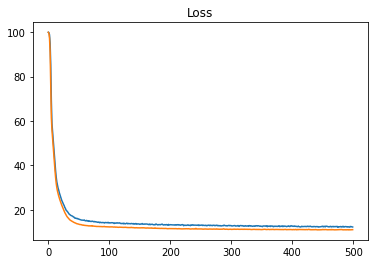

In [173]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [174]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [175]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.00%


In [176]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

In [177]:
blend_predict = (test_predict_catboost + test_predict_nn1[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.79%


## Model  NLP + Multiple Inputs

Посмотрим на столбец, который нужно обработать методами NLP:

In [178]:
description

0       Авто на бодром ходу.  Все работает отлично.  П...
1       Продажа от собственника, второй владелец, ПТС ...
2       Внимание! Только для клиентов AVILON Автомобил...
3       В комплекте зимние колёса. 27.07.2020 Замена п...
4       Отличный авто, 2011 года выпуска, кроме передн...
                              ...                        
8289    Продаётся любимица семьи. Автомобилем неактивн...
8290    В продаже автомобиль от компании АО ABTODOM, о...
8291    Машина в идеальном техническом состоянии. Обсл...
8292    Автомобиль приобретался новым у дилера Avilon ...
8293    ID: 38887\nКомплектация-Comfort\nГод выпуска в...
Name: description, Length: 8294, dtype: object

#### Очистка текста

Перед тем как проводить токенизацию, нужно почистить текст от неинформативных символов.

In [179]:
# оставим в тексте только русские слова
def clear_text(x):
    x = re.sub('[^а-яА-ЯёЁ]',' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower() 

In [180]:
new_description = description.apply(clear_text)

Посмотрим на очищенный текст:

In [181]:
new_description

0       авто на бодром ходу все работает отлично по эл...
1       продажа от собственника второй владелец птс ор...
2       внимание только для клиентов автомобили с проб...
3       в комплекте зимние колёса замена передних торм...
4       отличный авто года выпуска кроме переднего лев...
                              ...                        
8289    продаётся любимица семьи автомобилем неактивно...
8290    в продаже автомобиль от компании ао официальны...
8291    машина в идеальном техническом состоянии обслу...
8292    автомобиль приобретался новым у дилера в октяб...
8293     комплектация год выпуска в птс г два комплект...
Name: description, Length: 8294, dtype: object

#### Лемматизация и избавление от стоп-слов

Очистим наши данные от стоп-слов.

In [182]:
# стоп-слова, от которых можно очистить данные
stopWords = set(stopwords.words('russian'))
print(stopWords)

{'так', 'до', 'кто', 'уж', 'чтоб', 'из', 'было', 'еще', 'три', 'про', 'эту', 'ли', 'нет', 'тогда', 'были', 'этот', 'под', 'всех', 'при', 'вы', 'тут', 'них', 'себя', 'вдруг', 'над', 'ему', 'ним', 'меня', 'хоть', 'да', 'не', 'себе', 'а', 'на', 'я', 'иногда', 'об', 'от', 'свою', 'можно', 'конечно', 'ты', 'этом', 'во', 'что', 'хорошо', 'того', 'теперь', 'мы', 'ж', 'будет', 'всего', 'такой', 'том', 'есть', 'когда', 'чтобы', 'него', 'тем', 'раз', 'ей', 'лучше', 'то', 'может', 'нибудь', 'ведь', 'они', 'эти', 'мой', 'больше', 'впрочем', 'нас', 'другой', 'для', 'ее', 'без', 'с', 'всегда', 'со', 'зачем', 'надо', 'нее', 'здесь', 'или', 'все', 'никогда', 'даже', 'вас', 'будто', 'нельзя', 'уже', 'много', 'всю', 'там', 'потом', 'и', 'куда', 'вам', 'потому', 'сейчас', 'к', 'же', 'как', 'она', 'мне', 'этого', 'моя', 'два', 'после', 'какой', 'тот', 'вот', 'сам', 'он', 'где', 'им', 'чуть', 'наконец', 'их', 'опять', 'если', 'была', 'быть', 'перед', 'этой', 'о', 'за', 'только', 'ничего', 'был', 'его', 'че

Очистим наши данные от стоп-слов и слишком маленьких слов. <br>
Проведем лемматизацию.

In [183]:
lemmatizer = Mystem()

In [184]:
def stop_words_out(text):
    text = lemmatizer.lemmatize(text) # лемматизация текста
    text_2 = []
    for i in text:
        if len(i) > 2 and i not in stopWords:
            text_2.append(i)
    return ' '.join(text_2)

In [185]:
new_description_2 = new_description.apply(stop_words_out)

Посмотрим, что получилось после очистки и лемматизации:

In [186]:
new_description_2

0       авто бодрый ход работать отлично электрика ход...
1       продажа собственник второй владелец птс оригин...
2       внимание клиент автомобиль пробег предлагать с...
3       комплект зимний колесо замена передний тормозн...
4       отличный авто год выпуск кроме передний левый ...
                              ...                        
8289    продаваться любимица семья автомобиль неактивн...
8290    продажа автомобиль компания официальный дилер ...
8291    машина идеальный технический состояние обслужи...
8292    автомобиль приобретаться новый дилер октябрь г...
8293    комплектация год выпуск птс комплект ключ допо...
Name: description, Length: 8294, dtype: object

#### Токенизация

In [187]:
# split данных
text_train = new_description_2.iloc[X_train.index]
text_test = new_description_2.iloc[X_test.index]
text_sub = new_description_2.iloc[X_sub.index]

In [188]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [189]:
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(new_description_2)

In [190]:
# посмотрим на полученные слова:
tokenize.word_index

In [191]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5629, 256) (994, 256) (1671, 256)
CPU times: user 991 ms, sys: 517 µs, total: 991 ms
Wall time: 991 ms


In [192]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

второй владелец покупать годовалый немецкий сборка практически полный комплектация проекция лобовой стекло доводчик дверь люк камера задний вид автомобиль окрашиваться косметический цель дтп обслуживаться сервис желание подымать весь история
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0   

#### RNN NLP

In [193]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

#### MLP

In [194]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

#### Multiple Inputs NN

In [195]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

#### Fit

In [196]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [197]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [198]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
11/11 [==============================] - 6s 311ms/step - loss: 99.9967 - MAPE: 99.9967 - val_loss: 99.8994 - val_MAPE: 99.8994
Epoch 2/500
11/11 [==============================] - 3s 239ms/step - loss: 99.4997 - MAPE: 99.4997 - val_loss: 95.6765 - val_MAPE: 95.6765
Epoch 3/500
11/11 [==============================] - 3s 239ms/step - loss: 90.5413 - MAPE: 90.5413 - val_loss: 64.2787 - val_MAPE: 64.2787
Epoch 4/500
11/11 [==============================] - 3s 239ms/step - loss: 61.4381 - MAPE: 61.4381 - val_loss: 55.4234 - val_MAPE: 55.4234
Epoch 5/500
11/11 [==============================] - 3s 238ms/step - loss: 52.2886 - MAPE: 52.2886 - val_loss: 46.9880 - val_MAPE: 46.9880
Epoch 6/500
11/11 [==============================] - 3s 247ms/step - loss: 45.7211 - MAPE: 45.7211 - val_loss: 37.3088 - val_MAPE: 37.3088
Epoch 7/500
11/11 [==============================] - 3s 240ms/step - loss: 36.8441 - MAPE: 36.8441 - val_loss: 30.7596 - val_MAPE: 30.7596
Epoch 8/500
11/11 [========

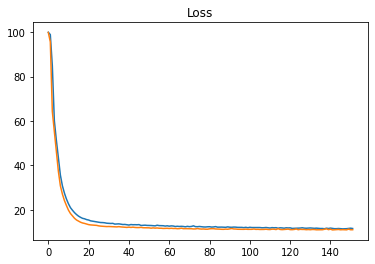

In [199]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [200]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [201]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 10.99%


Мы получили результат немного ниже чем на чисто табличных данных. Но это не критично. На лидербордере результат даже немного улучшился.

## Добавляем картинки

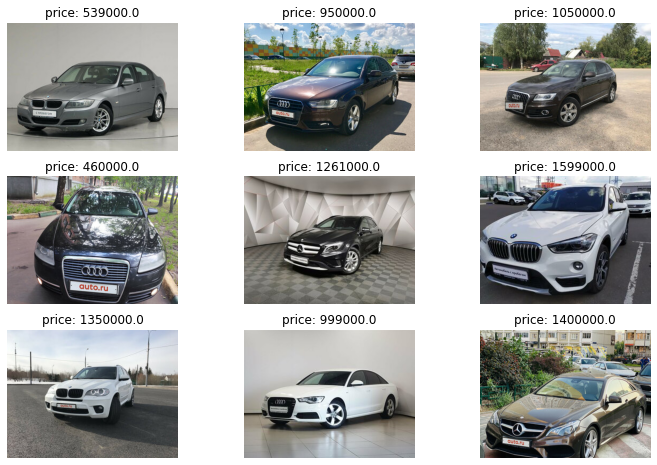

In [202]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [203]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(df_cv['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5629, 240, 320, 3) dtype uint8
images shape (994, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


#### albumentations

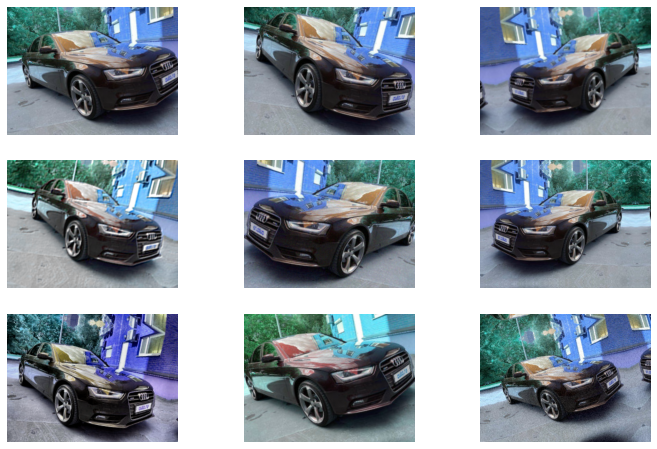

In [204]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [205]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [206]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(new_description_2)

In [207]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, new_description_2.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, new_description_2.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, new_description_2.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

#### Строим сверточную сеть для анализа изображений без "головы"

In [208]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [209]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [210]:
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [211]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 240, 320, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 240, 320, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [212]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [213]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [214]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
188/188 [==============================] - 146s 694ms/step - loss: 73.7486 - MAPE: 73.7486 - val_loss: 78.2033 - val_MAPE: 78.2033
Epoch 2/100
188/188 [==============================] - 125s 665ms/step - loss: 20.1508 - MAPE: 20.1508 - val_loss: 15.9012 - val_MAPE: 15.9012
Epoch 3/100
188/188 [==============================] - 126s 669ms/step - loss: 16.4642 - MAPE: 16.4642 - val_loss: 14.2550 - val_MAPE: 14.2550
Epoch 4/100
188/188 [==============================] - 125s 663ms/step - loss: 15.1752 - MAPE: 15.1752 - val_loss: 13.4933 - val_MAPE: 13.4933
Epoch 5/100
188/188 [==============================] - 126s 668ms/step - loss: 14.4414 - MAPE: 14.4414 - val_loss: 12.8558 - val_MAPE: 12.8558
Epoch 6/100
188/188 [==============================] - 125s 663ms/step - loss: 13.9034 - MAPE: 13.9034 - val_loss: 12.9216 - val_MAPE: 12.9216
Epoch 7/100
188/188 [==============================] - 127s 672ms/step - loss: 13.4696 - MAPE: 13.4696 - val_loss: 12.5246 - val_MAPE: 12.5246

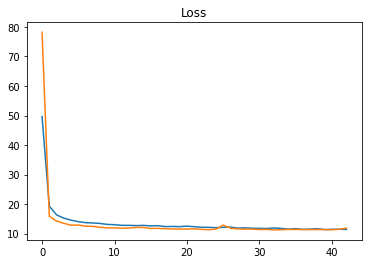

In [215]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [216]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [217]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.87%


Результат немного ухудшился по сравнению табличными данными и NLP.

## Blend

Объединим наши ML и лучшую DL модели для формирования итогового результата. 

In [223]:
blend_predict = (test_predict_catboost + test_predict_nn2[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.86%


Получился финальный результат. Его и отправим на **submission.**

In [220]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

На лидерборде получился результат MAPE = **11.35238**.<br>
Место **28** на момент отправки результата. <br>

### Итоги работы

1) Была произведена предварительная обработка данных: <br>
 - заполнение пропусков;
 - чистка и приведение данных к единому виду;
 - группировка данных;
 - исследование данных на выбросы;
 - стандартизация числовых данных;
 - преобразование категориальных признаков.<br>
 
2) Данные были проанализированы и визуализированы. Были рассмотрены: <br>
 - распределение числовых признаков;
 - оценка корреляций;
 - значимость числовых и категориальных переменных.<br>
 
3) Был применен алгоритм CatBoostRegressor. К алгоритму подобраны гиперпараметры.<br>
4) Признак **description** был обработан и очищен. Применена лемматизация. Были ислючены стоп-слова. Был применен алгоритм **NLP**.<br>
5) Был применен алгоритм **cv**, который в итоге не попал в финальную модель.<br>
6) Было призведено объединение моделей ML и DL. Результат был отправлен на 'submission' в конкурсе Kaggle.